In [1]:
#Copyright 2019 The TensorFlow Authors.

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 8_Tensorflow Hub with flower classification

#### Import packages

In [1]:
import tensorflow as tf
     
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
     
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#### Download the Flowers Dataset using TensorFlow Datasets

In [3]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

#### Print Information about the Flowers Dataset

In [4]:
num_classes = dataset_info.features['label'].num_classes
num_examples = dataset_info.splits['train'].num_examples

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Images: {}'.format(num_examples))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Images: 3670
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [5]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))
#Images are not the same size.

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


#### Reformat Images and Create Batches

In the cell below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. The function should take in an image and a label as arguments and should return the new image and corresponding label. Then create training and validation batches of size 32.

In [6]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

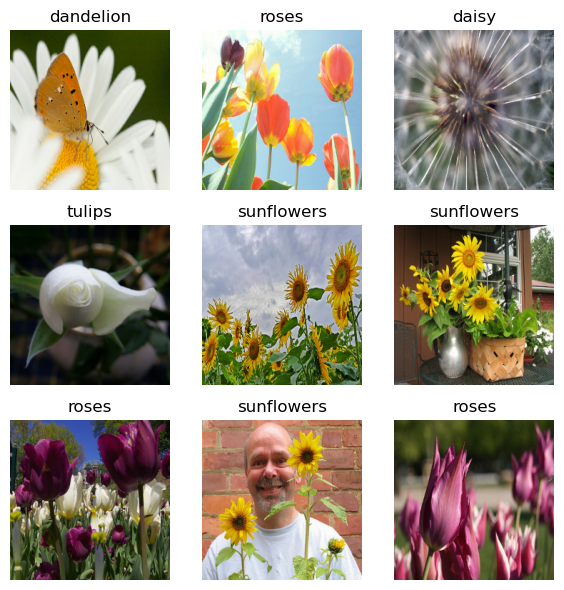

In [7]:
#Sample flower pictures and labels
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

plt.figure(figsize=(6,6))
for n in range(9):
  plt.subplot(3,3,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.title(class_names[label_batch[n]])
  plt.imshow(image_batch[n])
  plt.axis('off')

plt.tight_layout()

#### Simple Transfer Learning with TensorFlow Hub

Remember, in transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

##### Create a Feature Extractor
Remember that the partial model from TensorFlow Hub (without the final classification layer) is called a feature vector. Go to the [TensorFlow Hub documentation](https://www.kaggle.com/models?task=16701&query=tf2&tfhub-redirect=true) to see a list of available feature vectors. Click on the tf2-preview/mobilenet_v2/feature_vector. Read the documentation and get the corresponding URL to get the MobileNet v2 feature vector. Finally, create a feature_extractor by using hub.KerasLayer with the correct input_shape parameter.

In [137]:
IMAGE_RES = 224
#Define tensorflow hub layer
mobilenet_v2 = tf.keras.applications.MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(IMAGE_RES, IMAGE_RES, 3)
)
mobilenet_v2.trainable = False  # Freeze the pre-trained weights

#Build our layers
inputs = tf.keras.Input(shape=(IMAGE_RES, IMAGE_RES, 3))
x = mobilenet_v2(inputs)

#change tensorflow output into vectors
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#add classification layer
outputs = tf.keras.layers.Dense(num_classes)(x)

#build model from layers
model = tf.keras.Model(inputs, outputs)

In [138]:
#compile
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [139]:
model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

##### Train the model
In the cell bellow train this model like any other, by first calling compile and then followed by fit. Make sure you use the proper parameters when applying both methods. Train the model for only 6 epochs.

In [141]:
EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
17/81 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.2610 - loss: 1.7837

KeyboardInterrupt: 

We manage to get 90% validation set accuracy compared to 77% previously on our own model.

#### Plot Training and Validation Graphs

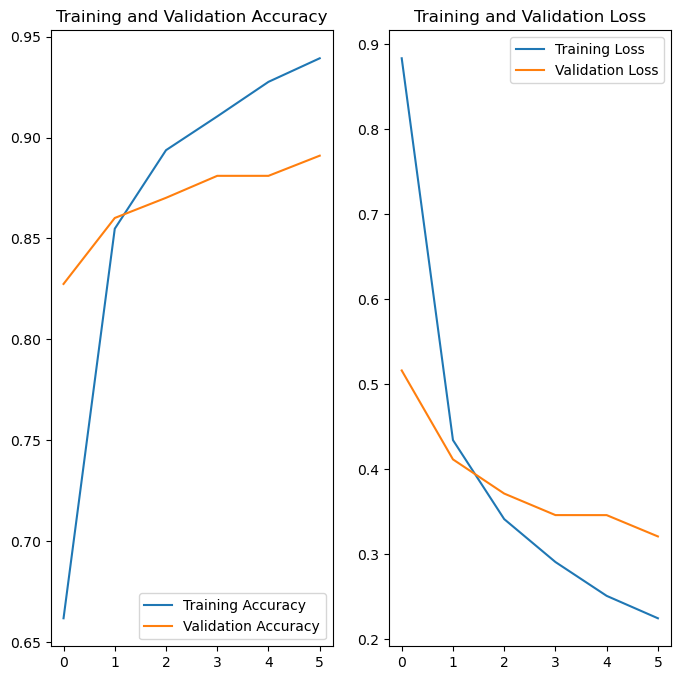

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Check Predictions

In [159]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

predicted_class_names = []
for x in predicted_ids:
    predicted_class_names.append(class_names[x])

predicted_class_names

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


['daisy',
 'daisy',
 'roses',
 'roses',
 'dandelion',
 'daisy',
 'sunflowers',
 'roses',
 'dandelion',
 'sunflowers',
 'sunflowers',
 'daisy',
 'roses',
 'daisy',
 'roses',
 'daisy',
 'daisy',
 'roses',
 'dandelion',
 'tulips',
 'daisy',
 'sunflowers',
 'tulips',
 'dandelion',
 'roses',
 'daisy',
 'daisy',
 'tulips',
 'sunflowers',
 'roses',
 'tulips',
 'sunflowers']

In [160]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 0 2 2 1 0 3 2 1 3 3 0 2 0 2 0 0 2 1 3 0 3 4 0 2 0 0 4 3 2 4 1]
Predicted labels:  [0 0 2 2 1 0 3 2 1 3 3 0 2 0 2 0 0 2 1 4 0 3 4 1 2 0 0 4 3 2 4 3]


#### Plot Model Predictions

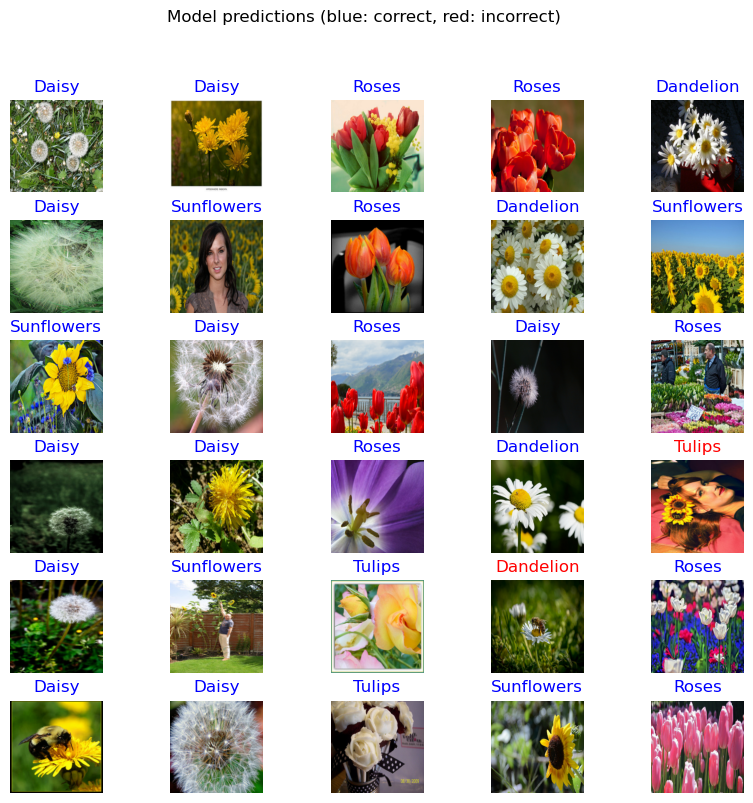

In [161]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

#### Perform Transfer Learning with the Inception Model

In [147]:
IMAGE_RES = 299

#format image function
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

#format image and batch size
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

#Tensorflow hub model
inception_v3 = tf.keras.applications.InceptionV3(
    weights='imagenet', include_top=False, input_shape=(IMAGE_RES, IMAGE_RES, 3)
)
inception_v3.trainable = False

#Build our layers
inputs = tf.keras.Input(shape=(IMAGE_RES, IMAGE_RES, 3))
x = inception_v3(inputs)

#change tensorflow output into vectors
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#add classification layer
outputs = tf.keras.layers.Dense(num_classes)(x)

#build model from layers
model = tf.keras.Model(inputs, outputs)

In [148]:
model.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,813,029 (83.21 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [149]:
model.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 62s 689ms/step - accuracy: 0.6062 - loss: 1.0190 - val_accuracy: 0.8465 - val_loss: 0.4802
Epoch 2/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 701ms/step - accuracy: 0.8621 - loss: 0.4255 - val_accuracy: 0.8801 - val_loss: 0.3743
Epoch 3/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 703ms/step - accuracy: 0.9018 - loss: 0.3251 - val_accuracy: 0.8810 - val_loss: 0.3524
Epoch 4/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 679ms/step - accuracy: 0.9116 - loss: 0.2741 - val_accuracy: 0.9010 - val_loss: 0.3079
Epoch 5/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 679ms/step - accuracy: 0.9290 - loss: 0.2376 - val_accuracy: 0.9001 - val_loss: 0.3004
Epoch 6/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 679ms/step - accuracy: 0.9459 - loss: 0.2087 - val_accuracy: 0.9001 - val_loss: 0.2897


Looks like the accuracy is comparable.

In [167]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

predicted_class_names = []
for x in predicted_ids:
    predicted_class_names.append(class_names[x])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


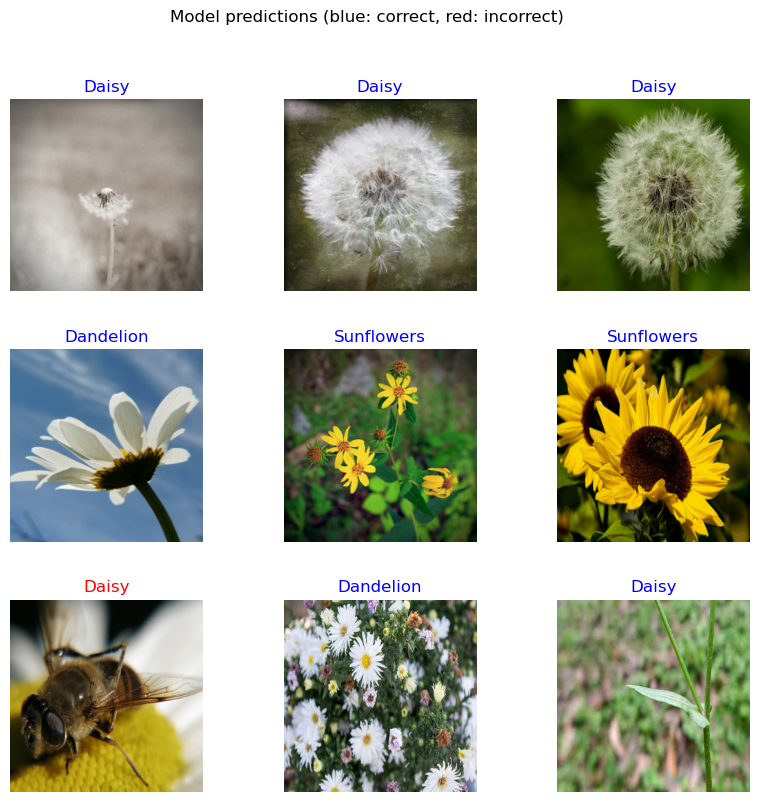

In [168]:
plt.figure(figsize=(10,9))
for n in range(9):
  plt.subplot(3,3,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

It looks like dandelion and daisy labels may be mislabeled but is consistent.